[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link]
<a href="javascript:void(0);" onclick="openJupyterWidget('https://github.com/nmfs-opensci/nmfshackdays-2025/blob/main/topics-2025/2025-opendap/6-nasa-pydap.ipynb');">
    <img src="https://img.shields.io/badge/Open_in_JupyterHub-orange?style=for-the-badge" alt="JupyterHub Badge">
</a> [![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link]

[download-link]: https://nmfs-opensci.github.io/NMFSHackDays-2025/topics-2025/2025-opendap/3-nasa.ipynb
[colab-link]: https://colab.research.google.com/github/nmfs-opensci/nmfshackdays-2025/blob/main/topics-2025/2025-opendap/6-nasa-pydap.ipynb
[jupyter-link]: https://nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/nmfs-opensci/nmfshackdays-2025/main/topics-2025/2025-opendap/6-nasa-pydap.ipynb

>📘 Learning Objectives
>
> 1. Repeat the NASA notebook but illustrating PyDAP authentication.

## Overview

See the 3-nasa.ipynb notebook for the recommended way to authenticate until pydap > 3.5.3 (Jan 2025) is released. This notebook is included to document PyDAP authentication. When the new version is released, this authentication works similar to token-based (meaning works for all cases tested).
```
import requests
my_session=requests.Session()
```

PyDAP will automatically look for `~/.netrc` file and use that so it may seem that you are not authenticating (if you have that file). But you are. The "silent" method fails if the data require a User Agreement (EULA) that you have to accept on your Earthdata profile because it cannot handle redirects. You can set up a session with username/password which will work for single files with `xarray.open_dataset` but fails with `xarray.open_mfdataset`. Setting up a session with a token works in all cases, but is more of a hassle. `earthaccess` will authenticate from your `~/.netrc` file and handle the token for you. So I recommend that approach.

I am going to first show how to set up a token and create a "session" that is passed to `xarray`. For what I have found (in March 2025), this works to get past "re-direct" errors that arise when the data require a EULA. Tokens also get past the redirect errors from other non-NASA OPeNDAP servers that use NASA EDL (USDA and NSIDC).  At the end, I will show how `xarray+pydap` can automatically use your `.netrc` file to authenticate, but this won't work for data that need a EULA so it might be best to use the token method as that will work for data that need a EULA too.

### References

* <https://podaac.jpl.nasa.gov/OPeNDAP-in-the-Cloud>

### Prerequisites

Set up a NASA EDL token. Go to <https://urs.earthdata.nasa.gov/profile> and click on Generate Token. Copy your token (it is exceedingly long) and paste into this code. Run this in a terminal windown (not notebook). Alternatively, open `~/.env` and paste in `NASA_EDL_TOKEN='your_edl_token_here'`. Note the token only last a month, so you will need to refresh your tokens regularly.

```
echo "NASA_EDL_TOKEN='your_edl_token_here'" >> ~/.env
```

Now we can load the token into any Jupyter notebook with
```
from dotenv import load_dotenv
load_dotenv()
edl_token = os.getenv("NASA_EDL_TOKEN")
```

For the section, where I cover authentication with username and password, I assume you have a `.netrc` file at `~` (home). `~/.netrc` should look just like this with your username and password. Create that file if needed.

```
machine urs.earthdata.nasa.gov
        login yourusername
        password yourpassword
```


### Packages


In [6]:
import xarray as xr
import pydap.client

## Three ways to authenticate with `pydap`

1. Let `pydap` find your `~/.netrc` file
2. Set up a session with your Earthdata username and password
3. Set up a session with a Earthdata token

I suggest you only use the latter since that works for all cases: data w or wo a EULA, singles files and multiple files, xarray `open_dataset` and `open_mfdataset`.

### Let pydap use your .netrc file

If the data need Earthdata authentication but don't need a EULA, then you can let `pydap` use your `.netrc` file silently. But this method is the most likely to produce redirect errors and access errors.

The following code works because `pydap` uses the .netrc file that is in `~/.netrc`. It does this silently for you. But this only works because this particular dataset does not require a User Agreement to be accepted on your Earthdata profile.

In [19]:
# doesn't need a eula
url="dap4://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0"
ds = xr.open_dataset(url, engine="pydap", decode_timedelta=False)
ds["wind_speed"].load()

<xarray.DataArray 'wind_speed' (/time: 1, /lat: 2400, /lon: 2400)> Size: 46MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ...,  8.,  8.,  8.],
        [nan, nan, nan, ...,  8.,  8., nan]]])
Dimensions without coordinates: /time, /lat, /lon
Attributes:
    long_name:      10m wind speed
    standard_name:  wind_speed
    units:          m s-1
    height:         10 m
    valid_min:      0
    valid_max:      127
    time_offset:    0.0
    source:         WSP-ECMWF-Forecast
    comment:        These wind speeds were created by the ECMWF and represent...
    Maps:           ()

### Set up a session with username and password

Using the `session` argument with `pydap` is more robust because it will open data that require a EULA. You can set up a session like this with your username and password in your .netrc file. This mostly works but it fails when using `xarray.open_mfdataset()` with data that require a EULA.  So using a token is better though more of a hassle. 

In [10]:
import netrc
# Get credentials from .netrc
auth_host = "urs.earthdata.nasa.gov"
try:
    credentials = netrc.netrc().authenticators(auth_host)
    if credentials:
        username, _, password = credentials
    else:
        raise ValueError("No credentials found in .netrc!")
except FileNotFoundError:
    raise FileNotFoundError("Could not find ~/.netrc. Ensure it exists and is configured correctly.")

In [12]:
import pydap
from pydap.client import open_url
from pydap.cas.urs import setup_session
pw_session = setup_session(username, password)

### Set up a session with a EDL token (pydap = 3.5.3)

This is the robust way to set up an authenticated session. Note see the notebook where I authenticate with `earthaccess`, which makes this easier and you don't need to save anything to `.env`.

Load the token. Make sure you have your token set up in your `~/.env` file. See prerequisites.

In [20]:
from dotenv import load_dotenv
import os
load_dotenv()
edl_token = os.getenv("NASA_EDL_TOKEN")

Next we set up a NASA EDL session with this token.

In [21]:
import requests
auth_hdr="Bearer " + edl_token
token_session = requests.Session()
token_session.headers={"Authorization": auth_hdr}

### If pydap version > 3.5.3

If you have pydap version > 3.5.3, then you do not need to generate your own token. You can use your `.netrc` file (with EDL username and password) and use this:

In [1]:
# uncomment to use
#import requests
#token_session=requests.Session()


For the rest of the notebook, the `token_session` will be used.

## Load non-EULA data

In [22]:
# doesn't point to specific file but we will spec protocol
url="https://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0"

# this is another test url that works for this example
# url="https://opendap.earthdata.nasa.gov/hyrax/data/nc/fnoc1.nc"

In [23]:
%%time
#from pydap.client import open_url
pydap_ds = pydap.client.open_url(url, protocol="dap4", session=token_session)

CPU times: user 13 ms, sys: 11.9 ms, total: 24.9 ms
Wall time: 744 ms


In [25]:
%%time
# getting the data does work
test_ds = pydap_ds['lat'][:]

CPU times: user 18 ms, sys: 628 µs, total: 18.6 ms
Wall time: 2.67 s


In [24]:
ds = xr.open_dataset(
    url.replace("https", "dap4", 1), engine="pydap", 
    decode_cf=False, session=token_session)

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/plot/utils.py:260: RuntimeWarning: overflow encountered in scalar absolute
  vlim = max(abs(vmin - center), abs(vmax - center))


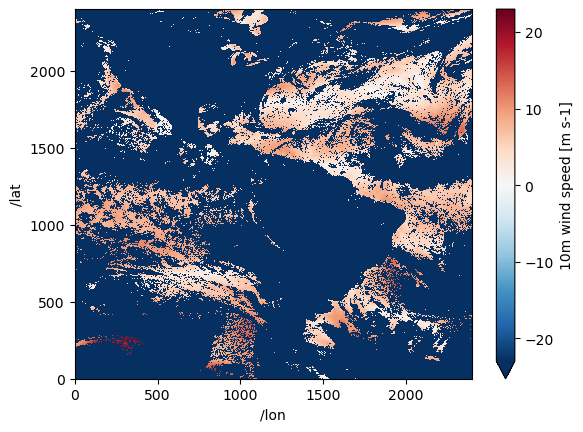

In [26]:
ds["wind_speed"].plot();

In [27]:
%%time
# This is doing the same thing as engine="pydap" I think but I don't have to know the dap4 replacement
# ds created is the same though
store = xr.backends.PydapDataStore(pydap_ds)
ds = xr.open_dataset(store, decode_cf=False)

CPU times: user 2.11 ms, sys: 0 ns, total: 2.11 ms
Wall time: 2.11 ms


## Data with a EULA

Letting `pydap` silently use your .netrc fails (redirect error) when there is a EULA and you have accepted the EULA. You need to set up a session with  username and password or with a token. 

### Prerequisites

Make sure you have the GESDISC EULA accepted.

1. Log into https://urs.earthdata.nasa.gov
2. Then go here https://urs.earthdata.nasa.gov/profile
3. Then click EULAs
4. Go to unaccepted EULAs and make sure that GESDISC is accepted


In [28]:
# the GESDISC data requires a EULA
eula_url = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXSLV.5.12.4/2016/06/MERRA2_400.tavg1_2d_slv_Nx.20160601.nc4'

In [29]:
%%time
import pydap
from pydap.client import open_url
pydap_ds = open_url(eula_url, session=token_session, protocol="dap4")

CPU times: user 41.3 ms, sys: 3.79 ms, total: 45.1 ms
Wall time: 1.58 s


In [30]:
# works when we try to get data
test_ds = pydap_ds['lat'][:]

In [31]:
%%time
# this works but is a lot of syntax to remember
ds = xr.open_dataset(eula_url.replace("https", "dap4", 1), 
                     engine="pydap", decode_cf=False, 
                     session=token_session)

CPU times: user 42.4 ms, sys: 3.77 ms, total: 46.2 ms
Wall time: 1.08 s


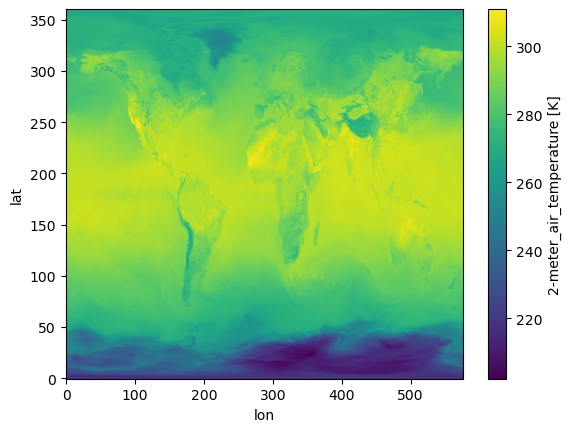

In [32]:
# yeah! I can get the data
ds = ds.rename({"/time": "time", "/lat": "lat", "/lon": "lon"})
ds["T2M"].isel(time=1).plot();

In [33]:
%%time
import xarray as xr
# This works too but is so much slower
store = xr.backends.PydapDataStore(pydap_ds)
ds = xr.open_dataset(store)

CPU times: user 35.4 ms, sys: 11.5 ms, total: 46.9 ms
Wall time: 2.47 s


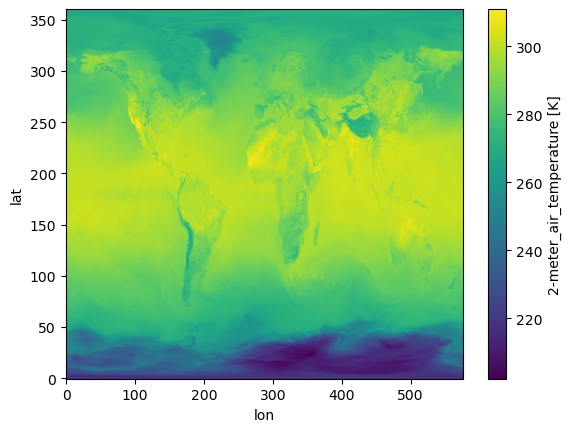

In [34]:
# I have to rename variables
ds = ds.rename({"/time": "time", "/lat": "lat", "/lon": "lon"})
ds["T2M"].isel(time=1).plot();

## Creating data cubes

Our goal is not individual files rather data cubes from multiple files. We will use `xarray.open_mfdataset` but we need to make some tweaks.

1. We need to use `dap4` instead of `https`. I don't know what to do if that doesn't work.
2. We need to concatenate using `\time` not `time` since the dim name has that slash in it.

### Example 1 Non-EULA data

In [35]:
# doesn't point to specific file but we will spec protocol
url1="dap4://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0"
url2="dap4://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220813010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220813_010000-v02.0-fv01.0"
urls = [url1, url2]
urls

['dap4://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0',
 'dap4://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220813010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220813_010000-v02.0-fv01.0']

In [36]:
ds = xr.open_mfdataset(urls, engine="pydap", 
                       combine="nested", 
                       concat_dim="/time", decode_cf=False,
                      session=token_session)
ds

<xarray.Dataset> Size: 288MB
Dimensions:                    (/time: 2, /lat: 2400, /lon: 2400)
Dimensions without coordinates: /time, /lat, /lon
Data variables: (12/19)
    wind_speed                 (/time, /lat, /lon) int8 12MB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
    lon                        (/time, /lon) float32 19kB dask.array<chunksize=(1, 2400), meta=np.ndarray>
    or_longitude               (/time, /lat, /lon) int16 23MB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
    time                       (/time) int32 8B dask.array<chunksize=(1,), meta=np.ndarray>
    sses_standard_deviation    (/time, /lat, /lon) int8 12MB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
    sst_dtime                  (/time, /lat, /lon) int32 46MB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
    ...                         ...
    dt_analysis                (/time, /lat, /lon) int8 12MB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
    satellite_zenith_angle     (/time, /lat, /lon) int8 12MB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
    lat                        (/time, /lat) float32 19kB dask.array<chunksize=(1, 2400), meta=np.ndarray>
    adi_dtime_from_sst         (/time, /lat, /lon) int8 12MB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
    or_latitude                (/time, /lat, /lon) int16 23MB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
    sses_bias                  (/time, /lat, /lon) int8 12MB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                CF-1.4
    title:                      Sea Surface Temperature
    summary:                    The L3C product derived from GOES16/ABI brigh...
    references:                 Geostationary Sea Surface Temperature Product...
    institution:                OSISAF
    comment:                    None
    ...                         ...
    netcdf_version_id:          4.6.3
    build_dmrpp:                3.20.9-91
    bes:                        3.20.9-91
    libdap:                     libdap-3.20.8-41
    configuration:              \n# TheBESKeys::get_as_config()\nAllowedHosts...
    invocation:                 build_dmrpp -c /tmp/conf_GGue -f /tmp/tmph648...

Let's do some slicing and see how fast we can get the data.

In [37]:
ds = ds.rename({"/time": "time", "/lat": "lat", "/lon": "lon"})

In [38]:
%%time
test = ds["wind_speed"].isel(time=1).load()

CPU times: user 32.1 ms, sys: 36 ms, total: 68.1 ms
Wall time: 6.08 s


### Example 2 EULA data

`token_session` is critical so that things don't go south with re-directs.

In [39]:
eula_url1 = 'dap4://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXSLV.5.12.4/2016/06/MERRA2_400.tavg1_2d_slv_Nx.20160601.nc4'
eula_url2 = 'dap4://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXSLV.5.12.4/2016/06/MERRA2_400.tavg1_2d_slv_Nx.20160602.nc4'
eula_urls = [eula_url1, eula_url2]

In [40]:
%%time
import xarray as xr
# very fast and this is 1Tb of data
ds = xr.open_mfdataset(eula_urls, engine="pydap", 
                       combine="nested", concat_dim="/time", 
                       decode_cf=False, session=token_session)
ds

CPU times: user 141 ms, sys: 12 ms, total: 153 ms
Wall time: 2.24 s


<xarray.Dataset> Size: 2GB
Dimensions:   (/time: 48, /lat: 361, /lon: 576)
Dimensions without coordinates: /time, /lat, /lon
Data variables: (12/50)
    U2M       (/time, /lat, /lon) float32 40MB dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    V250      (/time, /lat, /lon) float32 40MB dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    TROPT     (/time, /lat, /lon) float32 40MB dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    TROPPB    (/time, /lat, /lon) float32 40MB dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    T2M       (/time, /lat, /lon) float32 40MB dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    TQL       (/time, /lat, /lon) float32 40MB dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    ...        ...
    T2MWET    (/time, /lat, /lon) float32 40MB dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    U500      (/time, /lat, /lon) float32 40MB dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    QV10M     (/time, /lat, /lon) float32 40MB dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    lat       (/time, /lat) float64 139kB dask.array<chunksize=(24, 361), meta=np.ndarray>
    lon       (/time, /lon) float64 221kB dask.array<chunksize=(24, 576), meta=np.ndarray>
    time      (/time) int32 192B dask.array<chunksize=(24,), meta=np.ndarray>
Attributes: (12/31)
    History:                           Original file generated: Tue Jun 14 18...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Filename:                          MERRA2_400.tavg1_2d_slv_Nx.20160601.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    identifier_product_doi:            10.5067/VJAFPLI1CSIV
    RangeBeginningDate:                2016-06-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2016-06-01
    RangeEndingTime:                   23:59:59.000000
    Unlimited_Dimension:               time

In [41]:
print(f"Dataset size: {ds.nbytes/1e6:.2f} MB")

Dataset size: 1876.77 MB


In [42]:
# We can load the data
ds = ds.rename({"/time": "time", "/lat": "lat", "/lon": "lon"})
ds["T2M"].isel(time=1).load()

<xarray.DataArray 'T2M' (lat: 361, lon: 576)> Size: 832kB
array([[218.05759, 218.05759, 218.05759, ..., 218.05759, 218.05759,
        218.05759],
       [217.35446, 217.35446, 217.33884, ..., 217.38571, 217.38571,
        217.37009],
       [217.10446, 217.10446, 217.10446, ..., 217.10446, 217.10446,
        217.10446],
       ...,
       [266.9951 , 266.98727, 266.97946, ..., 267.01462, 267.0068 ,
        266.999  ],
       [268.10446, 268.10446, 268.10446, ..., 268.10056, 268.10056,
        268.10446],
       [269.124  , 269.124  , 269.124  , ..., 269.124  , 269.124  ,
        269.124  ]], dtype=float32)
Dimensions without coordinates: lat, lon
Attributes: (12/14)
    long_name:       2-meter_air_temperature
    units:           K
    _FillValue:      999999987000000.0
    missing_value:   999999987000000.0
    fmissing_value:  999999987000000.0
    scale_factor:    1.0
    ...              ...
    vmax:            999999987000000.0
    vmin:            -999999987000000.0
    valid_range:     [-999999987000000.0, 999999987000000.0]
    origname:        T2M
    fullnamepath:    /T2M
    Maps:            ()

Note, if you tried to use the username/password for creating the session instead of a token, you would get the redirect error.

### Example 3 from PyDap documentation

In this example, constraint expression is used just to get certain variables. See full notebook [here](https://pydap.github.io/pydap/notebooks/ECCO.html#add-a-constraint-expression-to-the-url-to-only-retrieve-theta).

In [43]:
baseURL = 'dap4://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/'
Temp_Salt = "ECCO%20Ocean%20Temperature%20and%20Salinity%20-%20Monthly%20Mean%20llc90%20Grid%20(Version%204%20Release%204)/granules/OCEAN_TEMPERATURE_SALINITY_mon_mean_"
year = '2017-'
month = '01'
end_ = '_ECCO_V4r4_native_llc0090'
CE = '?dap4.ce=/THETA;/SALT;/tile;/j;/k;/i;/time'

Temp_2017 = [baseURL + Temp_Salt + year + f'{i:02}' + end_ + CE for i in range(1, 4)]
Temp_2017

['dap4://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/ECCO%20Ocean%20Temperature%20and%20Salinity%20-%20Monthly%20Mean%20llc90%20Grid%20(Version%204%20Release%204)/granules/OCEAN_TEMPERATURE_SALINITY_mon_mean_2017-01_ECCO_V4r4_native_llc0090?dap4.ce=/THETA;/SALT;/tile;/j;/k;/i;/time',
 'dap4://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/ECCO%20Ocean%20Temperature%20and%20Salinity%20-%20Monthly%20Mean%20llc90%20Grid%20(Version%204%20Release%204)/granules/OCEAN_TEMPERATURE_SALINITY_mon_mean_2017-02_ECCO_V4r4_native_llc0090?dap4.ce=/THETA;/SALT;/tile;/j;/k;/i;/time',
 'dap4://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/ECCO%20Ocean%20Temperature%20and%20Salinity%20-%20Monthly%20Mean%20llc90%20Grid%20(Version%204%20Release%204)/granules/OCEAN_TEMPERATURE_SALINITY_mon_mean_2017-03_ECCO_V4r4_native_llc0090?dap4.ce=/THETA;/SALT;/tile;/j;/k;/i;/time']

Create data cube with `open_mfdataset` but not concat dim is `/time` not `time`. This takes a really long time, but if we didn't do the constraint expression part, it would take much longer. So it is good to do that step.

Note `token_session` is not required since these data don't need a EULA, but good practice to use.

In [44]:
%%time
# 13 seconds to assemble the data cube for a 126Mb dataset...slow
theta_salt_ds = xr.open_mfdataset(
    Temp_2017, 
    engine='pydap',
    parallel=True, 
    combine='nested', 
    concat_dim='/time',
    session=token_session
)
theta_salt_ds

CPU times: user 184 ms, sys: 12.7 ms, total: 196 ms
Wall time: 13 s


<xarray.Dataset> Size: 126MB
Dimensions:  (/time: 3, /k: 50, /tile: 13, /j: 90, /i: 90)
Coordinates:
    time     (/time) datetime64[ns] 24B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: /time, /k, /tile, /j, /i
Data variables:
    SALT     (/time, /k, /tile, /j, /i) float32 63MB dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    THETA    (/time, /k, /tile, /j, /i) float32 63MB dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    i        (/time, /i) int32 1kB dask.array<chunksize=(1, 90), meta=np.ndarray>
    j        (/time, /j) int32 1kB dask.array<chunksize=(1, 90), meta=np.ndarray>
    k        (/time, /k) int32 600B dask.array<chunksize=(1, 50), meta=np.ndarray>
    tile     (/time, /tile) int32 156B dask.array<chunksize=(1, 13), meta=np.ndarray>
Attributes: (12/62)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               2017-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             2017-01-01T00:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            f5b7028c-4181-11eb-b7e6-0cc47a3f47b1

In [94]:
print(f"Dataset size: {theta_salt_ds.nbytes/1e6:.2f} MB")

Dataset size: 126.36 MB


In [142]:
theta_salt_ds = theta_salt_ds.rename({"/time": "time", "/j": "j", "/i": "i", "/tile": "tile", "/k": "k"})

/tmp/ipykernel_1511/704975482.py:1: UserWarning: rename '/time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  theta_salt_ds = theta_salt_ds.rename({"/time": "time", "/j": "j", "/i": "i", "/tile": "tile", "/k": "k"})


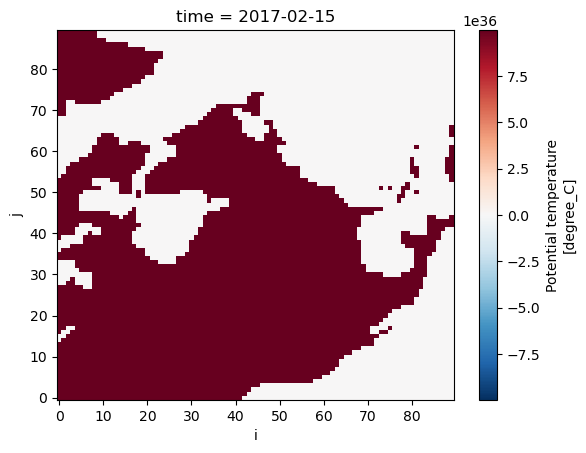

In [146]:
theta_salt_ds["THETA"].isel(time=1, tile=10, k=1).plot()

## Conclusion

Use token-based sessions with `pydap` to ensure no redirect gotchas.

## References

* <https://pydap.github.io/pydap/intro.html>
* <https://opendap.github.io/documentation/tutorials/ClientAuthentication.html#_pydap>
* <https://github.com/OPENDAP/NASA-tutorials/tree/main>
* <https://pydap.github.io/pydap/notebooks/Authentication.html>

